## Setup of a basic simulation
In this notebook, we set up a basic simulation where a vessel moves over a 1D network path. The example aims to provides a basic understanding of some key OpenTNSim core functions and shows what an OpenTNSim model run looks like. 

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation(s)](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [6]:
#packages related to time, space, and id
import datetime, time
import platform
import random
import os
import pathlib
import io
import urllib
import tempfile
import functools
import logging
import pickle
import pathlib
import importlib

# package(s) related to the simulation (creating the vessel, running the simulation)
import simpy
import opentnsim
import openclsim
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

# package(s) needed for inspecting the output
import pandas as pd


# package(s) needed for data handling
import requests
import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=ShapelyDeprecationWarning)

# package(s) used for creating and geo-locating the graph (spatial libraries)
import networkx as nx  
import shapely.geometry
import shapely.wkt
import pyproj
from osgeo import ogr, osr
from simplekml import Kml, Style
import folium

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

In [9]:
src_dir = pathlib.Path(opentnsim.__file__).parent.parent

# Graph location
location_graph = src_dir / "notebooks"
name_graph = location_graph / "Shape-Files" / "Rotterdam-Antwerpen-corridor" / "edges_2.shp"

#Vessel database
location_vessel_database = 'C:\Arash\Van Oord\Pengerang\Pengerang_Vessels.csv'

### 2. Create vessel
A real-world database of Van Oord Trailing suction hopper dredgers and Water injection dredgers is generated.

The following characteristics of each of these vessels are determined.
* Dimensions and weights of vessels
* Draught of TSHDs when the hopper is full and empty
* Fuel consumption of vessels and their emission factor
* Installed power of vessels for propulsion, dredging, etc.
* Capacity of hoppers
* Sailing speed of vessels (for Hoppers full/empty)
* Resistance of vessels (for hoppers full/empty)
* Production of vessels
* Maximum dredging depth of vessels

In [12]:
vessel_db = pd.read_csv(os.path.join(location_graph, location_vessel_database))
vessel_db.head(None)

,Vessel Name,width,length,draught_empty,draught_full,fuel_consumption,emission_factor,installed_power,own_weight,capacity_full,capacity_empty,speed_full,speed_empty,is_full,production,type,max_dredging_depth,min_dredging_depth
0,Sagar Manthan,11.28,46.50,2.33,1.53,NaN,0.54,2106,661,0.000,0,0.8,0.8,NaN,NaN,WID,20.0,4.0
1,HAM 311,17.02,94.11,3.68,5.68,NaN,0.75,5317,6519,3701.528,0,11.5,12.2,NaN,NaN,TSHD,29.6,27.5
2,Volvox Asia,26.04,140.83,3.65,7.92,NaN,0.77,21453,12987,10834.020,0,16.0,17.0,NaN,NaN,TSHD,35.0,35.0


In [13]:
# Make a class out of mix-ins
TransportResource = type(
    'TransportResource', 
                         (core.Identifiable, core.Movable, 
                          core.HasResource, core.Routeable, core.HasContainer, core.ExtraMetadata), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

# create a dict with all important settings
data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(4.0092314, 51.4598245),  # lon, lat
               "capacity": 1_000,
               "v": 1}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

### 3. Create graph
OpenTNSim works with mix-in classes to allow for flexibility in defining nodes.

A graph contains nodes (blue dots in plot below) and edges (red arrows in plot below). 

Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 7 edges. The edges are made bi-directional to allow for two-way traffic, exept for one edge. This enables us to select two different routes between two nodes.

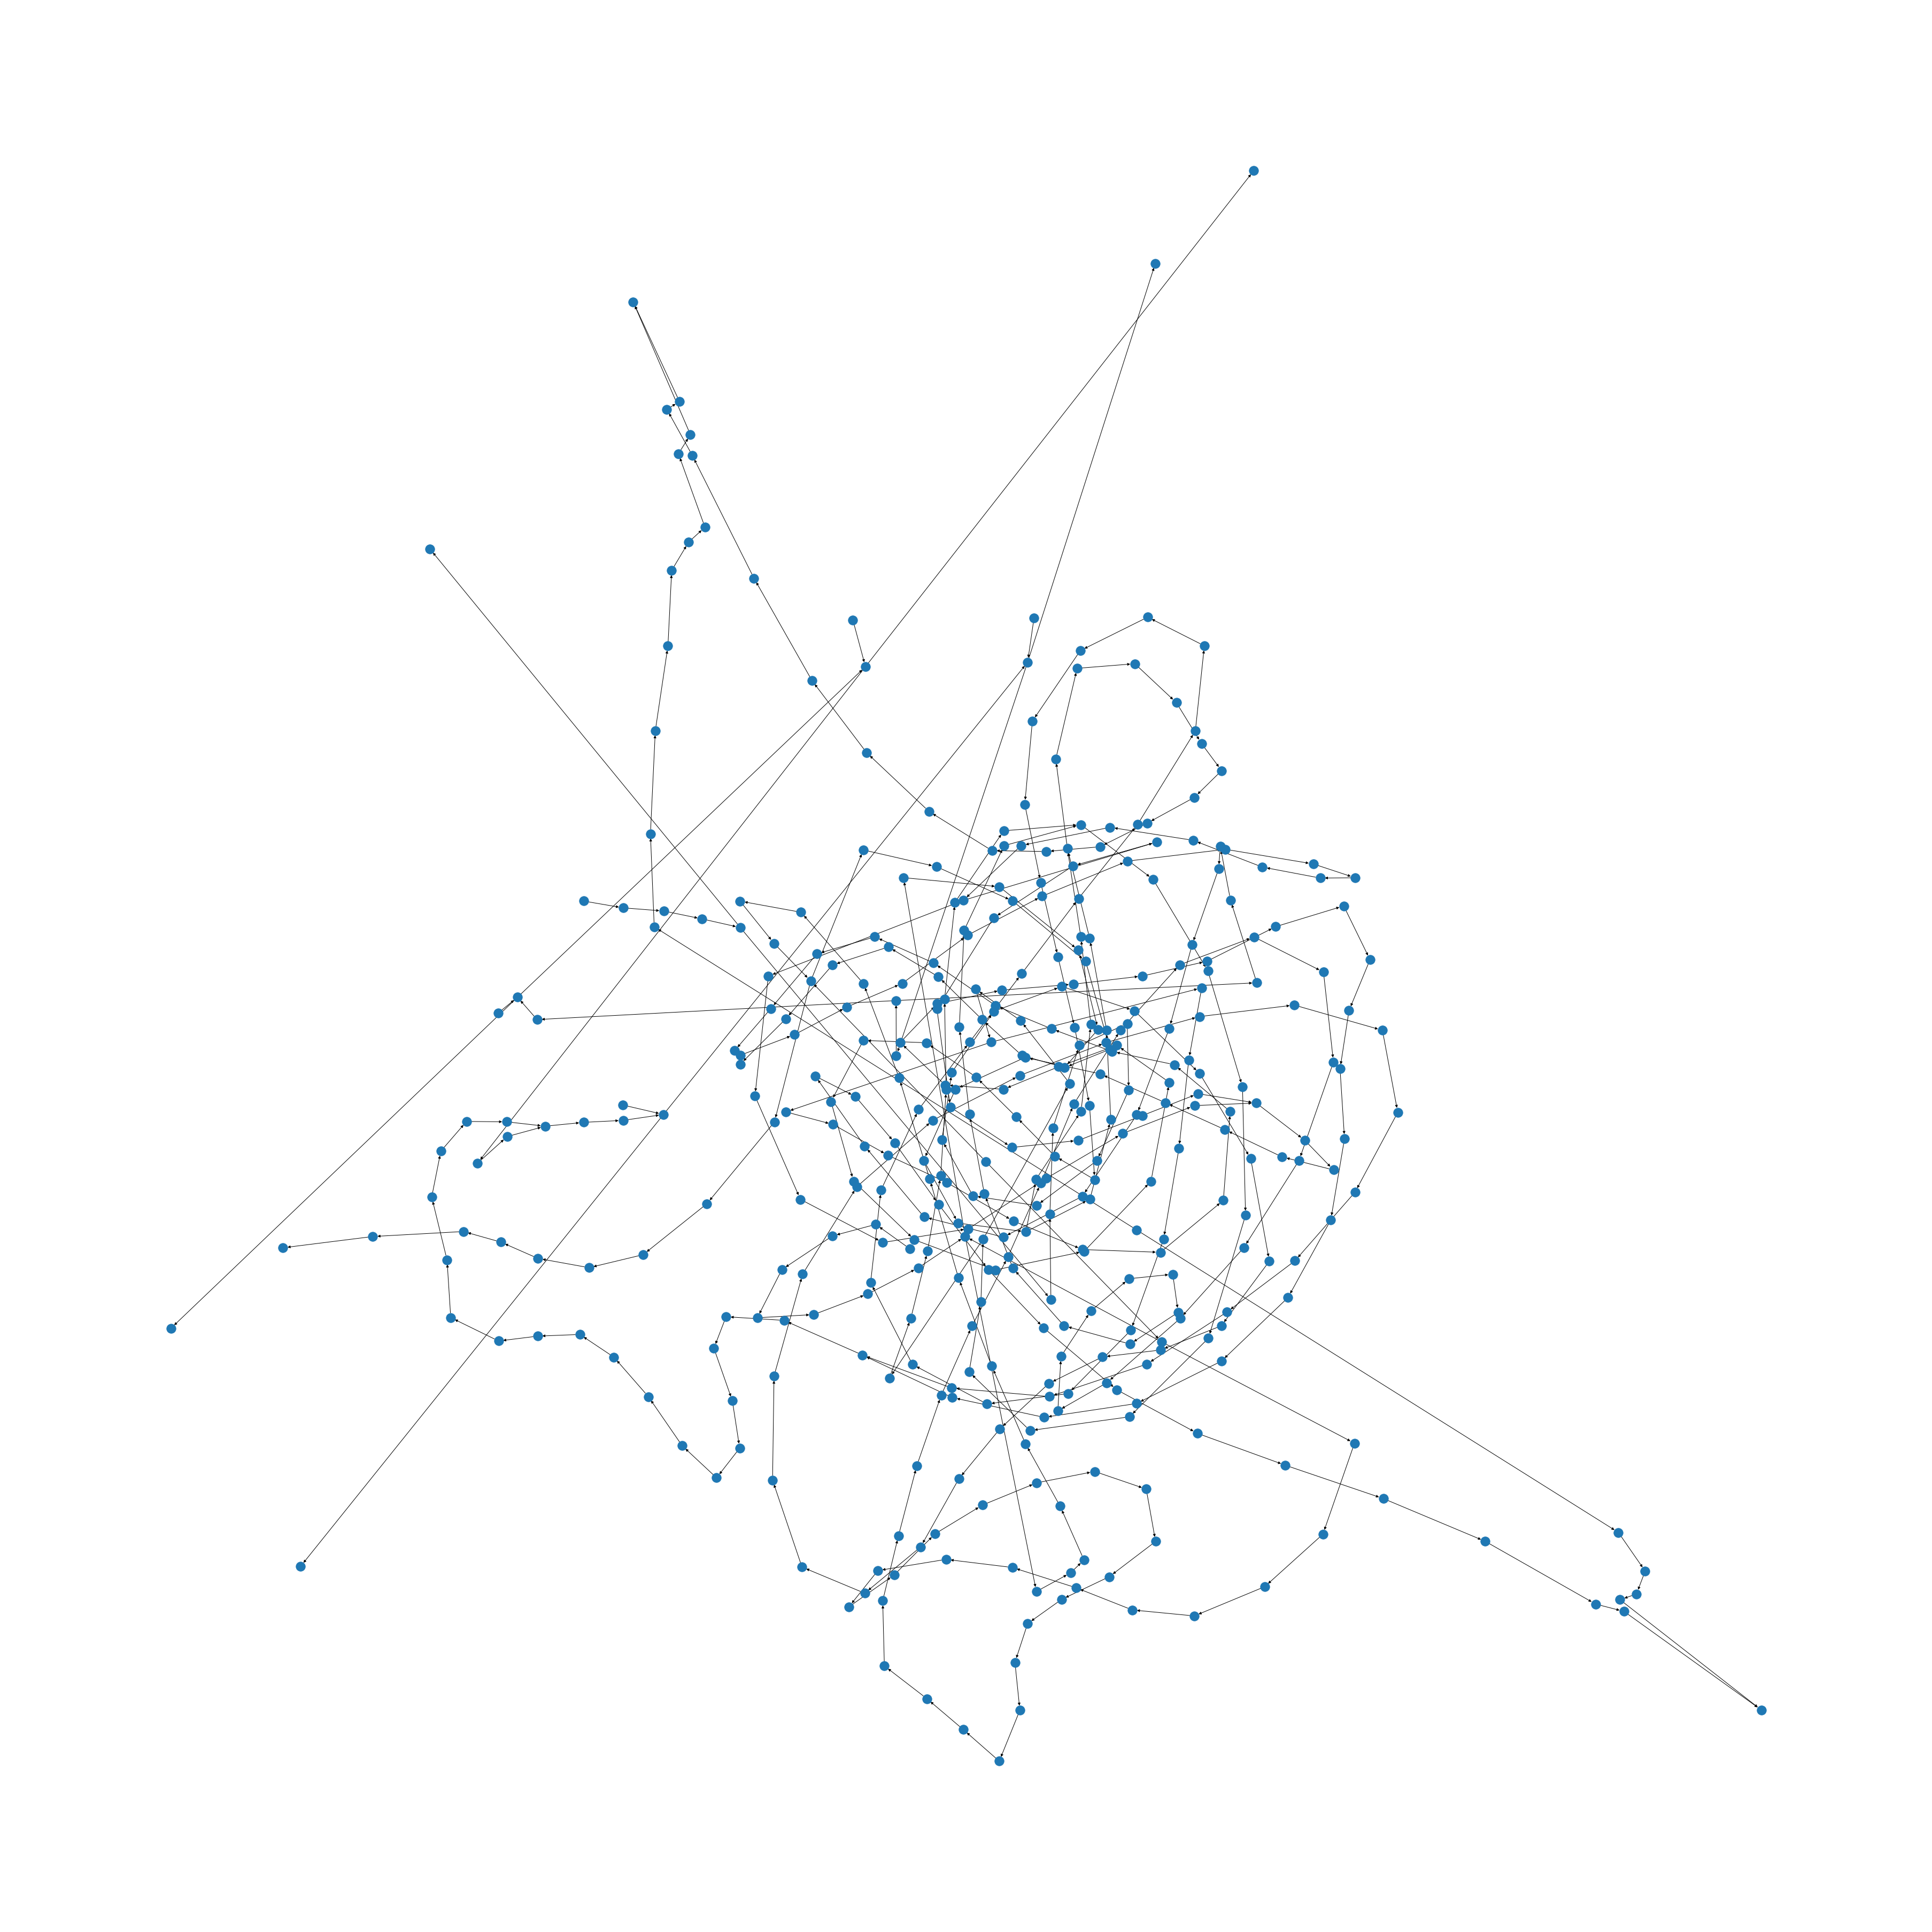

In [14]:
# Read the shape-file
FG = nx.read_shp(str(name_graph), simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(50,50))
nx.draw(FG)

# Show the drawing
plt.show()

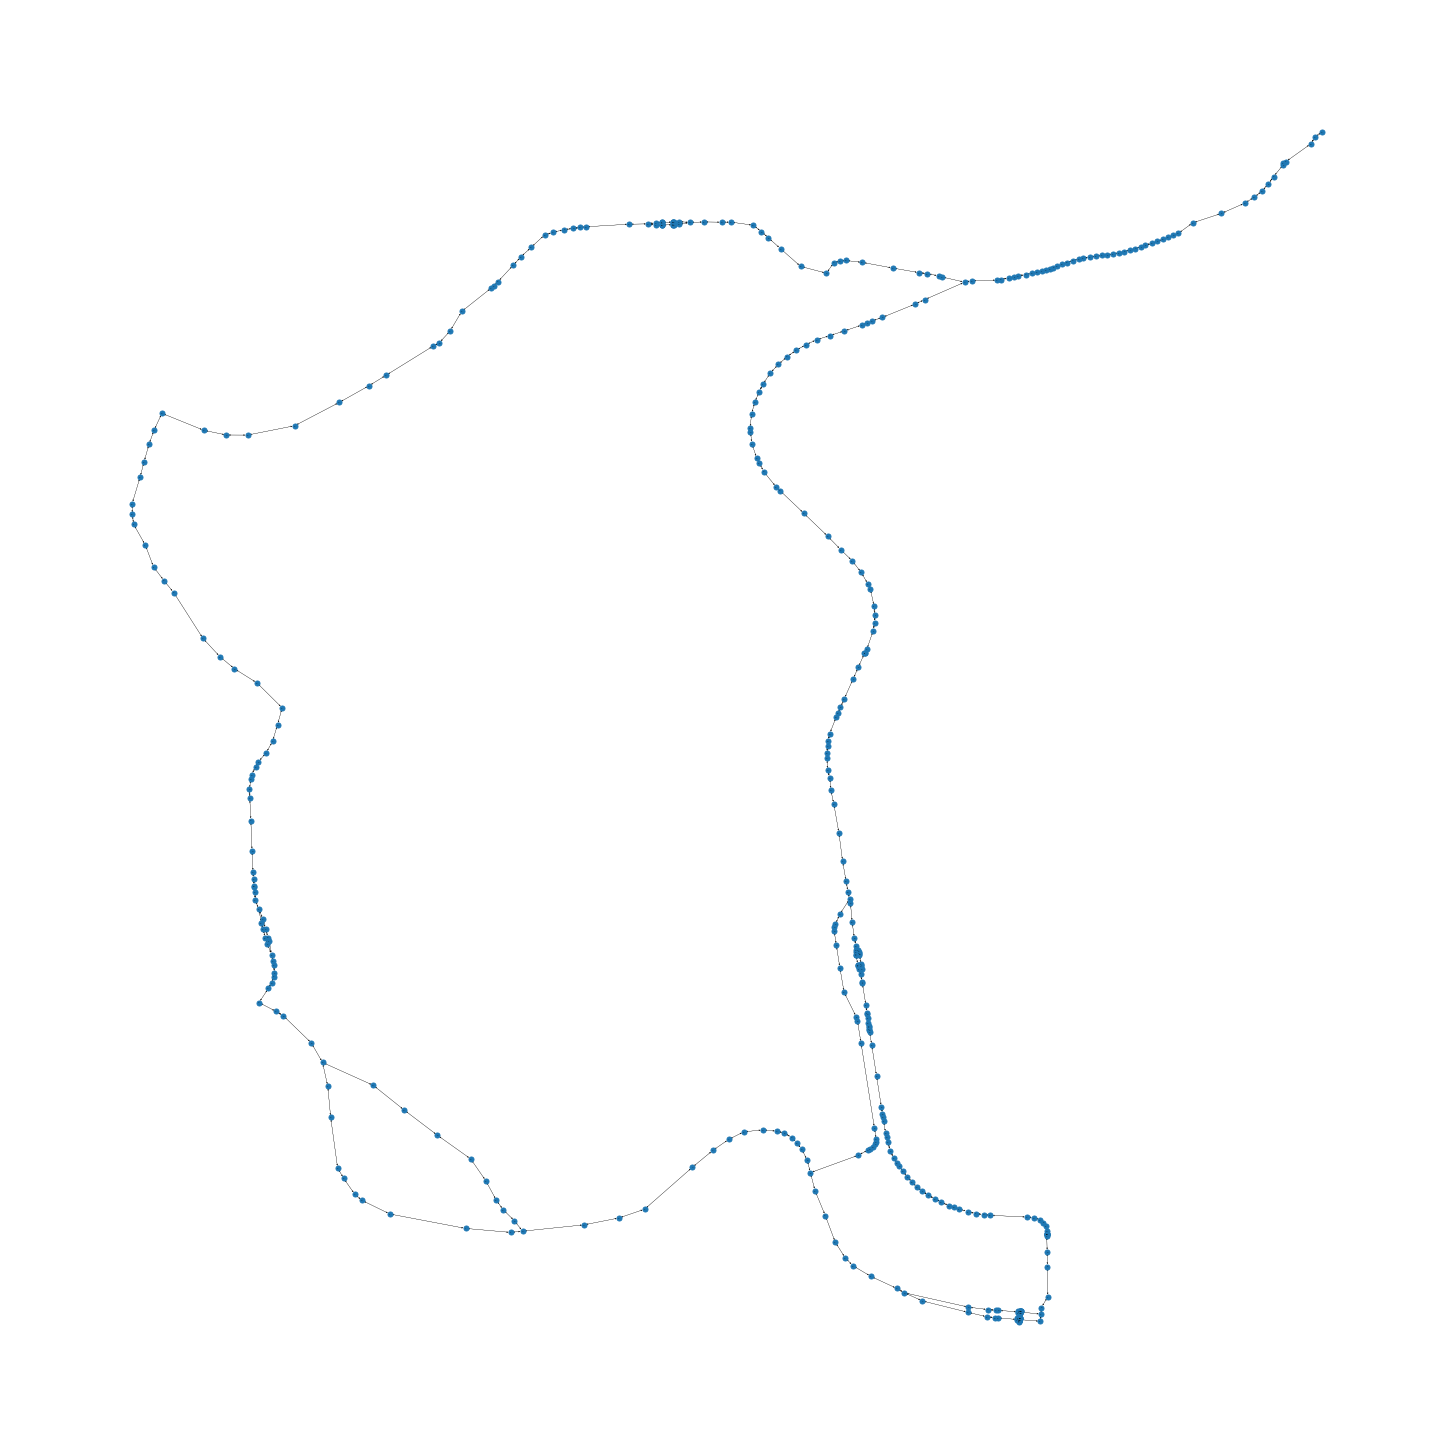

In [6]:
# calculate distance between two points
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    orig = shapely.geometry.shape(orig)
    dest = shapely.geometry.shape(dest)
    
    distance = wgs84.inv(orig.x, orig.y, 
                         dest.x, dest.y)[2]
    
    return distance

H_G = nx.Graph()

lat_lon_to_index = {}
edge_id_counter = 0

for i, node in enumerate(FG.nodes(data = True)):
    H_G.add_node(i, pos = node[0], 
                    name = "Node {}".format(i),
                    geometry = shapely.geometry.Point(node[0][0], node[0][1]))
    lat_lon_to_index[node[0]] = i

    
for edge in FG.edges(data=True): 
    H_G.add_edge(lat_lon_to_index[edge[0]], 
                 lat_lon_to_index[edge[1]],
                 dis= calculate_distance(nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[1]]], 
                                         nx.get_node_attributes(H_G, 'geometry')[lat_lon_to_index[edge[0]]]))

FG = H_G.to_directed()
plt.figure(figsize=(20,20))
nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels=True, node_size=25, font_size = 0.5, width = 0.2, arrowsize = 3)
plt.show()

### Define paths

In [7]:
# select 2 nodes on the graph
source = 80
target = 287
path = nx.dijkstra_path(FG, source, target)
print(path)

[80, 81, 94, 95, 96, 303, 74, 304, 315, 395, 383, 253, 254, 255, 88, 89, 90, 109, 287]


### Claculation of energy consumption and emissions per time step


In [15]:
class EnergyCalculation:
    """
    Add information on energy use and effects on energy use.
    """

    def __init__(self, vessel, *args, **kwargs):
        super().__init__(*args, **kwargs)

        """Initialization"""
        self.vessel = vessel
        
        self.energy_use = {"time_start": [], 
                           "time_stop": [], 
                           "edge_start": [],
                           "edge_stop": [],
                           "total_energy": [], 
                           "total_emission_CO2": [],
                           "total_emission_PM10": [], 
                           "total_emission_NOX": [], 
                           "stationary": [],
                           "water depth": [],
                           "distance": [],
                           "delta_t": []}
        
        self.co2_footprint = {"total_footprint": 0, "stationary": 0}
        self.mki_footprint = {"total_footprint": 0, "stationary": 0}

    def calculate_energy_consumption(self):
        """Calculation of energy consumption based on total time in system and properties"""

        def calculate_distance(geom_start, geom_stop):
            """method to calculate the distance in meters between two geometries"""
            wgs84 = pyproj.Geod(ellps='WGS84')

            # distance between two points
            return float(wgs84.inv(geom_start.x, geom_start.y,
                                 geom_stop.x,  geom_stop.y) [2])
        
        def calculate_depth(geom_start, geom_stop):
            """method to calculate the depth of the waterway in meters between two geometries"""
            depth = 0
            
            #The node on the graph of vaarweginformatie.nl closest to geom_start and geom_stop 
            
            node_start = find_closest_node(FG, geom_start)[0]
            node_stop = find_closest_node(FG, geom_stop)[0]
            
            #Read from the FG data from vaarweginformatie.nl the General depth of each edge
            try:#if node_start != node_stop:
                depth = FG.get_edge_data(node_start, node_stop)["Info"]["GeneralDepth"]
            except:
                depth = np.nan     #When there is no data of the depth available of this edge, it gives a message
            
            h = depth
            
            # depth of waterway between two points
            return h
        
        
        # log messages that are related to locking
        stationary_phase_indicator = [
            "Waiting to enter waiting area stop",
            "Waiting in waiting area stop",
            "Waiting in line-up area stop",
            "Passing lock stop",
        ]
        
        # extract relevant elements from the vessel log
        times = self.vessel.log["Timestamp"]
        messages = self.vessel.log["Message"]
        geometries = self.vessel.log["Geometry"]

        # now walk past each logged event (each 'time interval' in the log corresponds to an event)
        for i in range(len(times) - 1):
            # determine the time associated with the logged event (how long did it last)
            delta_t = (times[i + 1] - times[i]).total_seconds()
            
            if delta_t != 0:
                # append time information to the variables for the dataframe
                self.energy_use["time_start"].append(times[i])
                self.energy_use["time_stop"].append(times[i + 1])
                
                # append geometry information to the variables for the dataframe
                self.energy_use["edge_start"].append(geometries[i])
                self.energy_use["edge_stop"].append(geometries[i + 1])
        
                # calculate the distance travelled and the associated velocity 
                distance = calculate_distance(geometries[i], geometries[i + 1])
                V_0 = distance / delta_t
                self.energy_use["distance"].append(distance)
                
                # calculate the delta t
                self.energy_use["delta_t"].append(delta_t)
                
                # calculate the water depth
                h = calculate_depth(geometries[i], geometries[i + 1]) 
                
                # printstatements to check the output (can be removed later)
                print('delta_t: {:.4f} s'. format(delta_t))
                print('distance: {:.4f} m'. format(distance))
                print('velocity: {:.4f} m/s'. format(V_0))
                
                # we use the calculated velocity to determine the resistance and power required
                self.vessel.calculate_total_resistance(V_0, h)
                self.vessel.calculate_total_power_required()
                
                self.vessel.calculate_emission_factors_total()

                if messages[i + 1] in stationary_phase_indicator:  # if we are in a stationary stage only log P_hotel
                    #Energy consumed per time step delta_t in the stationary stage
                    energy_delta = self.vessel.P_hotel * delta_t / 3600  # kJ/3600 = kWh
                    
                    #Emissions CO2, PM10 and NOX, in gram - emitted in the stationary stage per time step delta_t, consuming 'energy_delta' kWh
                    emission_delta_CO2 = self.vessel.Emf_CO2 * energy_delta # in g
                    emission_delta_PM10 = self.vessel.Emf_PM10 * energy_delta # in g
                    emission_delta_NOX = self.vessel.Emf_NOX * energy_delta # in g
                    
                    self.energy_use["total_energy"].append(energy_delta)
                    self.energy_use["stationary"].append(energy_delta)
                    self.energy_use["total_emission_CO2"].append(emission_delta_CO2)
                    self.energy_use["total_emission_PM10"].append(emission_delta_PM10)
                    self.energy_use["total_emission_NOX"].append(emission_delta_NOX)
                    
                    if not np.isnan(h):
                        self.energy_use["water depth"].append(h)
                    else: 
                        self.energy_use["water depth"].append(self.energy_use["water depth"].iloc[i])
                


                else:  # otherwise log P_tot
                    #Energy consumed per time step delta_t in the propulsion stage
                    energy_delta = self.vessel.P_tot * delta_t / 3600  # kJ/3600 = kWh
                   
                    #Emissions CO2, PM10 and NOX, in gram - emitted in the propulsion stage per time step delta_t, consuming 'energy_delta' kWh
                    emission_delta_CO2 = self.vessel.Emf_CO2 * energy_delta #Energy consumed per time step delta_t in the stationary phase # in g
                    emission_delta_PM10 = self.vessel.Emf_PM10 * energy_delta # in g
                    emission_delta_NOX = self.vessel.Emf_NOX * energy_delta # in g
    
                    self.energy_use["total_energy"].append(energy_delta)
                    self.energy_use["stationary"].append(0)
                    self.energy_use["total_emission_CO2"].append(emission_delta_CO2)
                    self.energy_use["total_emission_PM10"].append(emission_delta_PM10)
                    self.energy_use["total_emission_NOX"].append(emission_delta_NOX)
                    self.energy_use["water depth"].append(h)
                    #self.energy_use["water depth info from vaarweginformatie.nl"].append(depth)

        
        # TODO: er moet hier een heel aantal dingen beter worden ingevuld
        # - de kruissnelheid is nu nog per default 1 m/s (zie de Movable mixin). Eigenlijk moet in de 
        #   vessel database ook nog een speed_loaded en een speed_unloaded worden toegevoegd. 
        # - er zou nog eens goed gekeken moeten worden wat er gedaan kan worden rond kustwerken 
        # - en er is nog iets mis met de snelheid rond een sluis


    def plot(self):
        
        import folium

        df = pd.DataFrame.from_dict(energycalculation.energy_use)

        m = folium.Map(location=[51.7, 4.4], zoom_start = 12)

        line = []
        for index, row in df.iterrows():
            line.append((row["edge_start"].y, row["edge_start"].x))

        folium.PolyLine(line, weight = 4).add_to(m)

        return m

### Run simulation

Now we run a simulation for the two constructed paths

In [8]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        print(vessel.geometry)
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [9]:
# Start simpy environment
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = FG

# Add environment and path to the vessel
vessel.env = env
vessel.route = path
vessel.geometry = nx.get_node_attributes(FG, "geometry")[path[0]]

# Start the simulation
env.process(start(env, vessel))
env.run()

print("Simulation of path {} took {} seconds".format(path, int(env.now - env.epoch)))

POINT (4.2057029 51.3965224)
Simulation of path [80, 81, 94, 95, 96, 303, 74, 304, 315, 395, 383, 253, 254, 255, 88, 89, 90, 109, 287] took 9116 seconds


### Obtain vessel log information
The cel below uses the vessel log. The core function *log_entry* is used, which takes four arguments:

- **Log.** A text to describe what is logged.
- **t.** The timestamp.
- **Value.**  The value for the log (for sailing this is the distance).
- **Geometry** The location of the vessel while loggin.

In [10]:
vessel_log = pd.DataFrame.from_dict(vessel.log)
vessel_log.head()

,Message,Timestamp,Value,Geometry
0,Start sailing,2022-10-05 12:40:29.000000,,POINT (4.2898595 51.3462538)
1,Sailing from node 80 to node 81 start,2022-10-05 12:40:29.000000,0,POINT (4.2898595 51.3462538)
2,Sailing from node 80 to node 81 stop,2022-10-05 12:40:57.779383,0,POINT (4.2898218 51.3459962)
3,Sailing from node 81 to node 94 start,2022-10-05 12:40:57.779383,0,POINT (4.2898218 51.3459962)
4,Sailing from node 81 to node 94 stop,2022-10-05 12:49:30.014840,0,POINT (4.2825009 51.3464185)


### Visualization of path
If you get an error regarding ffmpeg use [this](https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available) answer. You have to install ffmpeg in your Conda environment. It can be done using the following command.

```bash
#Install ffmpeg using Conda
conda install -c conda-forge ffmpeg
```

In [11]:
geom_x = []
geom_y = []

for geom in vessel_log["Geometry"]:
    geom_x.append(geom.x)
    geom_y.append(geom.y)

vessel_log["Geometry - x"] = geom_x
vessel_log["Geometry - y"] = geom_y

vessel_log.head()

,Message,Timestamp,Value,Geometry,Geometry - x,Geometry - y
0,Start sailing,2022-10-05 12:40:29.000000,,POINT (4.2898595 51.3462538),4.289860,51.346254
1,Sailing from node 80 to node 81 start,2022-10-05 12:40:29.000000,0,POINT (4.2898595 51.3462538),4.289860,51.346254
2,Sailing from node 80 to node 81 stop,2022-10-05 12:40:57.779383,0,POINT (4.2898218 51.3459962),4.289822,51.345996
3,Sailing from node 81 to node 94 start,2022-10-05 12:40:57.779383,0,POINT (4.2898218 51.3459962),4.289822,51.345996
4,Sailing from node 81 to node 94 stop,2022-10-05 12:49:30.014840,0,POINT (4.2825009 51.3464185),4.282501,51.346418


In [12]:
geom_x = []
geom_y = []

for geom in vessel.log["Geometry"]:
    geom_x.append(geom.x)
    geom_y.append(geom.y)

vessel.log["Geometry - x"] = geom_x
vessel.log["Geometry - y"] = geom_y

time_stamp_min = min(vessel.log["Timestamp"]).timestamp()
time_stamp_max = max(vessel.log["Timestamp"]).timestamp()

steps = int(np.floor((time_stamp_max - time_stamp_min) / 60))
timestamps_t = np.linspace(time_stamp_min, time_stamp_max, steps)

times = []
for t in vessel.log["Timestamp"]:
    times.append(t.timestamp())

vessel.log["timestamps_t"] = timestamps_t
vessel.log["timestamps_x"] = np.interp(timestamps_t, times, vessel.log["Geometry - x"])
vessel.log["timestamps_y"] = np.interp(timestamps_t, times, vessel.log["Geometry - y"])

timestamps_t = vessel.log["timestamps_t"] 
timestamps_x = vessel.log["timestamps_x"]
timestamps_y = vessel.log["timestamps_y"]

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: 

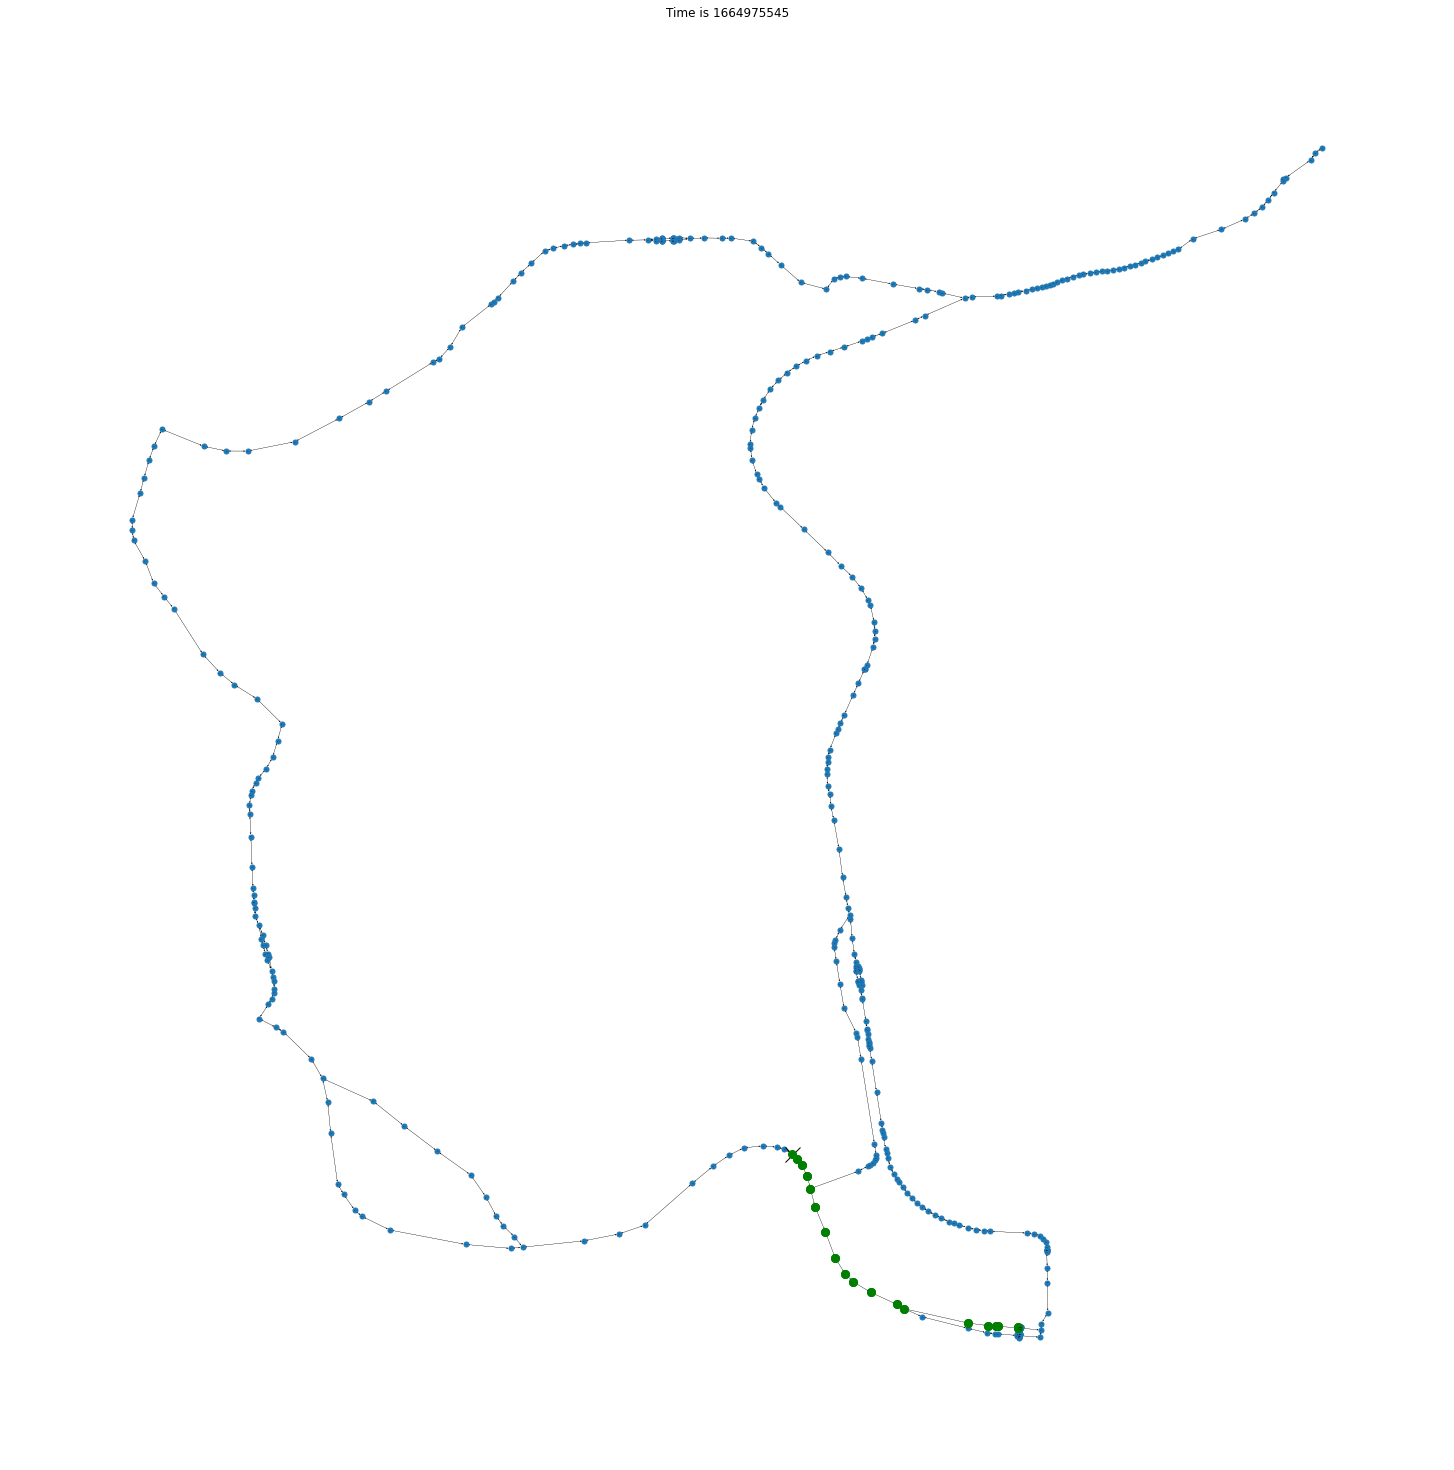

In [13]:
%%time

# Get the coordinates of every step
coordinates = []
for i in vessel.log["Geometry"]:
    coordinates.append((i.x, i.y))
    
# Get the time of every step
timesteps = []
for i in vessel.log["Timestamp"]:
    timesteps.append(i.timestamp())

# Make the animation
fig = plt.figure(figsize = [20, 20])

nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, node_size=25, font_size = 0.5, width = 0.2, arrowsize = 3)

location, = plt.plot([], [], 'kx', markersize=15)
path, = plt.plot([], [], 'go', markersize=8)
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [coordinates[i][0]]
    this_y = [coordinates[i][1]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timesteps[i])))
    
    if 0 < i:
        past_x = [coordinate[0] for coordinate in coordinates[:i]]
        past_y = [coordinate[1] for coordinate in coordinates[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timesteps)), init_func=init)
ani.save('Example 06 - route', fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

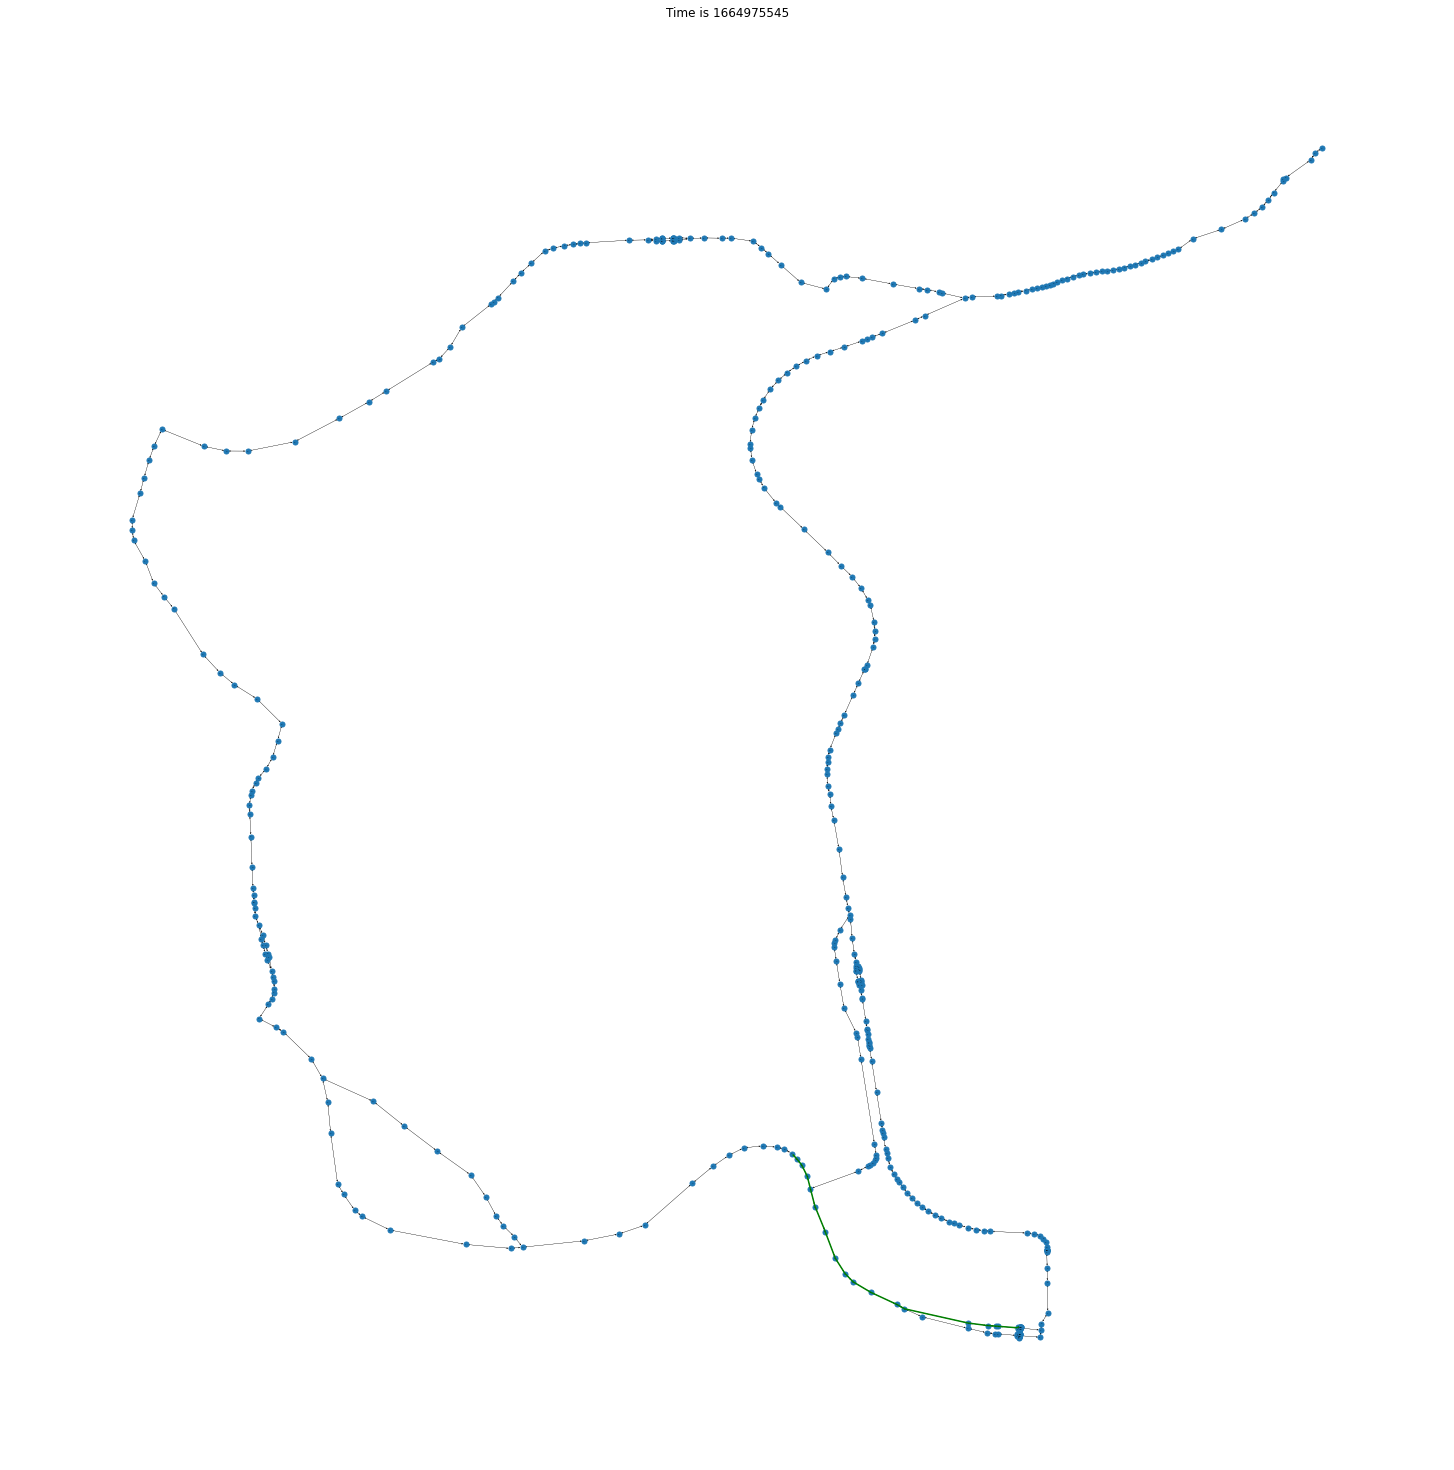

In [14]:
%%time

# Make the animation
fig = plt.figure(figsize = [20, 20])

nx.draw(FG, nx.get_node_attributes(FG, 'pos'), 
        with_labels = True, node_size=25, font_size = 0.5, width = 0.2, arrowsize = 3)

location, = plt.plot([], [], 'ko', markersize=15)
path, = plt.plot([], [], 'g')
time_text = plt.title("")

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")

def animate(i):
    this_x = [timestamps_x[i]]
    this_y = [timestamps_x[i]]
    
    location.set_data(this_x, this_y)
    time_text.set_text("Time is {}".format(int(timestamps_t[i])))
    
    if 0 < i:
        past_x = [x for x in timestamps_x[:i]]
        past_y = [y for y in timestamps_y[:i]]
        
        path.set_data(past_x, past_y)
    
        return location, path, time_text
    
    else:
        return location, time_text
    
        
ani = animation.FuncAnimation(fig, animate, np.arange(0, len(timestamps_t)), init_func=init)
ani.save('Example 06 - route - improved.mp4', fps=5)